In [1]:
import os
import rasterio as rio
import numpy as np
import shapely
import pyproj
import geopandas as gpd
import matplotlib.pyplot as plt
import rioxarray as riox
import rasterio as rio
import xarray as xr
import netCDF4
from osgeo import gdal
import pandas as pd
from datetime import datetime
import dask.array
from scipy.stats import linregress

In [2]:
# define folder and file paths
folder_HMA = os.path.join('C:',os.sep,'Users','lzell','OneDrive - Colostate','Desktop',"HMA2")
folder_glaciers = os.path.join(folder_HMA, 'Glacier Products')
folder_datasets = os.path.join(folder_HMA, 'Datasets')
fp_rgi = os.path.join(folder_HMA, 'Datasets', 'AOI definition', 'Final AOI', "Final Products", 'AOI_full_rgi.shp')
fp_regions = os.path.join(folder_HMA, 'Datasets', 'AOI definition', 'Final AOI', "Final Products", 'subregion_boundaries.shp')

In [3]:
# open the rgi gdf, regions gdf
rgi_gdf = gpd.read_file(fp_rgi).to_crs("ESRI:102025")
regions_gdf = gpd.read_file(fp_regions).to_crs("ESRI:102025")
print(regions_gdf.crs)
print(rgi_gdf.crs)

ESRI:102025
ESRI:102025


In [4]:
# process each glacier
c=0
for idx, row in rgi_gdf.iterrows():
    c+=1
    # if c>1: continue

    # grab glacier regions, rgiid, area
    rgi_id = row['rgi_id']
    o1region = row['o1region']
    o2region = row['o2region']
    
    # if o1region!='15': continue
    # if rgi_id != "RGI2000-v7.0-G-15-09257": continue
    
    # print progress
    if c%50==0: print(c, "of", len(rgi_gdf), rgi_id)
    
    # open glacier mask, debris mask
    path_open = os.path.join(folder_glaciers, rgi_id, 'Base Products', 'debris_mask.tif')
    xr_dmask = riox.open_rasterio(path_open, masked=False).squeeze(drop=True)
    xr_dmask = xr_dmask.where(xr_dmask==1)
    
    # open dem, distances
    path_open = os.path.join(folder_glaciers, rgi_id, 'Base Products', 'glacier_dem.tif')
    xr_dem = riox.open_rasterio(path_open, masked=False).squeeze(drop=True)
    
    path_open = os.path.join(folder_glaciers, rgi_id, 'Base Products', 'debris_distances.tif')
    xr_distances = riox.open_rasterio(path_open, masked=False).squeeze(drop=True)
    
    # open dhdt info for this glacier
    path_open = os.path.join(folder_glaciers, rgi_id, 'Base Products', 'glacier_dhdt_distances.csv')
    df_dhdt = pd.read_csv(path_open)
    
    # open glacier branch product
    path_open = os.path.join(folder_glaciers, rgi_id, 'Base Products', 'debris_glacier_branches.tif')
    xr_branches = riox.open_rasterio(path_open, masked=False).squeeze(drop=True)
    
    # count number of branches
    branch_ns = np.unique(xr_branches)
    branch_ns = branch_ns[~np.isnan(branch_ns)].astype(int)
    
    # for each branch, calculate slope
    all_branch_dfs = []
    for n in branch_ns:
        
        # subset elevation and distances to this branch
        xr_distances_n = xr_distances.where(xr_branches==n, np.nan)
        xr_dem_n = xr_dem.where(xr_branches==n, np.nan)
        df_dhdt_n = df_dhdt[f'{n}_2000-01-01_2010-01-01']
        
        # calculate max, min distance
        ds = np.unique(xr_distances_n)
        ds = np.sort(ds[~np.isnan(ds)])
        max_distance = np.nanmax(ds)
        min_distance = np.nanmin(ds)

        zs = []

        # calculate median elevation at each elevation band
        for d in ds:
            dem_d = np.nanmedian(xr_dem_n.where(xr_distances_n==d, np.nan))
            zs.append(dem_d)

        # make into df
        df_zs = pd.DataFrame({'distance':ds, f'{n}_z':zs})

        # calculate moving window elevation, and moving window slope
        df_zs[f'{n}_z_smooth'] = df_zs.rolling(25, min_periods=1, center=True).mean()[f'{n}_z']
        sl = df_zs[f'{n}_z'].rolling(25, min_periods=1, center=True) \
                                .apply(lambda s: linregress(s.reset_index())[0]) / 20
        df_zs[f'{n}_slope'] = np.degrees(np.arctan(sl))
        
        ##### use the 2010-2020 dhdt to forward-model the change in glacier elevation profile, slope
        # 2020
        df_zs[f'{n}_z_2020'] = df_zs[f'{n}_z'] + df_dhdt_n*10
        df_zs[f'{n}_z_smooth_2020'] = df_zs.rolling(25, min_periods=1, center=True).mean()[f'{n}_z_2020']
        sl = df_zs[f'{n}_z_2020'].rolling(25, min_periods=1, center=True) \
                                .apply(lambda s: linregress(s.reset_index())[0]) / 20
        df_zs[f'{n}_slope_2020'] = np.degrees(np.arctan(sl))
        
        # 2030
        df_zs[f'{n}_z_2030'] = df_zs[f'{n}_z'] + df_dhdt_n*20
        df_zs[f'{n}_z_smooth_2030'] = df_zs.rolling(25, min_periods=1, center=True).mean()[f'{n}_z_2030']
        sl = df_zs[f'{n}_z_2030'].rolling(25, min_periods=1, center=True) \
                                .apply(lambda s: linregress(s.reset_index())[0]) / 20
        df_zs[f'{n}_slope_2030'] = np.degrees(np.arctan(sl))
        
        #2040
        df_zs[f'{n}_z_2040'] = df_zs[f'{n}_z'] + df_dhdt_n*30
        df_zs[f'{n}_z_smooth_2040'] = df_zs.rolling(25, min_periods=1, center=True).mean()[f'{n}_z_2040']
        sl = df_zs[f'{n}_z_2040'].rolling(25, min_periods=1, center=True) \
                                .apply(lambda s: linregress(s.reset_index())[0]) / 20
        df_zs[f'{n}_slope_2040'] = np.degrees(np.arctan(sl))
        
        #2050
        df_zs[f'{n}_z_2050'] = df_zs[f'{n}_z'] + df_dhdt_n*40
        df_zs[f'{n}_z_smooth_2050'] = df_zs.rolling(25, min_periods=1, center=True).mean()[f'{n}_z_2050']
        sl = df_zs[f'{n}_z_2050'].rolling(25, min_periods=1, center=True) \
                                .apply(lambda s: linregress(s.reset_index())[0]) / 20
        df_zs[f'{n}_slope_2050'] = np.degrees(np.arctan(sl))
        
        # add to all_branch_dfs
        all_branch_dfs.append(df_zs.set_index('distance'))
    
    # concat all dfs together at the end
    all_branch_dfs = pd.concat(all_branch_dfs, axis=1).reset_index()

    # save to csv
    out_path = os.path.join(folder_glaciers, rgi_id, 'Base Products', 'glacier_slopes.csv')
    all_branch_dfs.to_csv(out_path, index=False)
        # break
    # break
print("All done!")

50 of 769 RGI2000-v7.0-G-13-14611
100 of 769 RGI2000-v7.0-G-13-24023
150 of 769 RGI2000-v7.0-G-13-48300
200 of 769 RGI2000-v7.0-G-14-01890
250 of 769 RGI2000-v7.0-G-14-08548
300 of 769 RGI2000-v7.0-G-14-19825
350 of 769 RGI2000-v7.0-G-14-26878
400 of 769 RGI2000-v7.0-G-14-30996
450 of 769 RGI2000-v7.0-G-15-00060
500 of 769 RGI2000-v7.0-G-15-01541
550 of 769 RGI2000-v7.0-G-15-03560
600 of 769 RGI2000-v7.0-G-15-05619
650 of 769 RGI2000-v7.0-G-15-07503
700 of 769 RGI2000-v7.0-G-15-09257
750 of 769 RGI2000-v7.0-G-15-15685
All done!


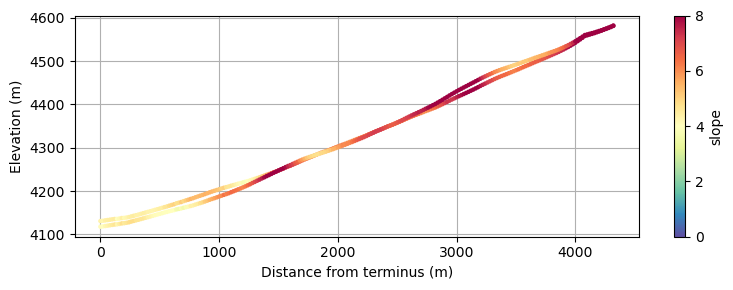

In [5]:
fig,axs = plt.subplots(figsize=(8,3))
# ax2 = axs.twinx()

for i,n in enumerate(branch_ns):
    p = axs.scatter( all_branch_dfs['distance'], all_branch_dfs[f'{n}_z_smooth'], zorder=2,
                 s=5, c=all_branch_dfs[f'{n}_slope'], cmap='Spectral_r', vmin=0, vmax=8)
    
    p = axs.scatter( all_branch_dfs['distance'], all_branch_dfs[f'{n}_z_smooth_2050'], zorder=2,
                 s=5, c=all_branch_dfs[f'{n}_slope_2050'], cmap='Spectral_r', vmin=0, vmax=8)
    
    # ax2.plot(all_branch_dfs['distance'], all_branch_dfs[f'{n}_slope'])
plt.colorbar(p, label='slope')
axs.set_xlabel("Distance from terminus (m)")
axs.set_ylabel("Elevation (m)")
axs.grid(zorder=1)
plt.tight_layout()


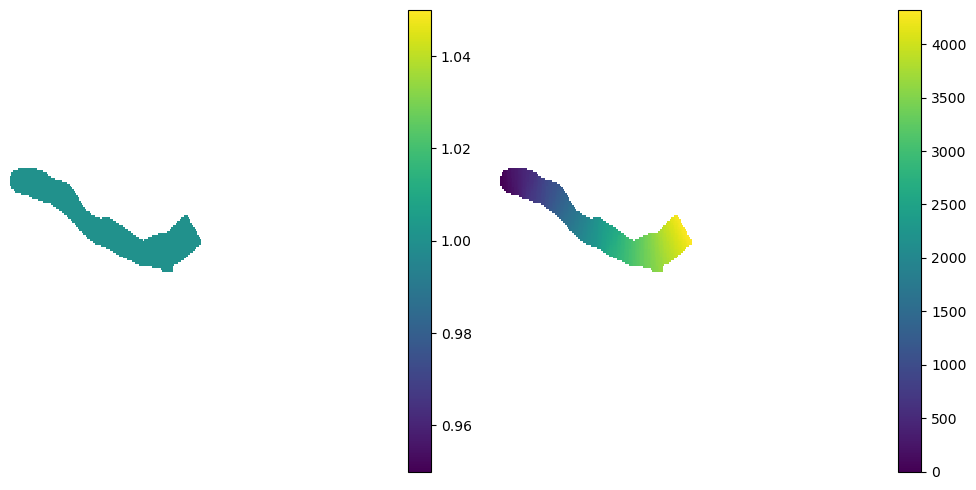

In [6]:
fig,axs = plt.subplots(1,2, figsize=(10,5))
xr_branches.plot(ax=axs[0])
xr_distances.plot(ax=axs[1])
for ax in axs:
    ax.axis('off')
    ax.set_title("")
plt.tight_layout()